In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
root_dir = '/root/hoai_workspace/stock-price-prediction/'

# Import

In [3]:
import os
import time
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
class StockChartDataset(object):
    def __init__(self, dir_path, transforms):
        self.dir_path = dir_path
        self.transforms = transforms
        df = pd.read_csv(dir_path + 'target.csv')
        self.imgs = df.filename.tolist()
        self.log_target = df.target.tolist()

    def __getitem__(self, idx):
        # Load images
        img_path = os.path.join(self.dir_path, self.imgs[idx])
        img = Image.open(img_path).convert('RGB')
        
        target = torch.tensor([self.log_target[idx]])

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [6]:
df = pd.read_csv(root_dir + 'data/dji_2009-2019.csv')
df['close_log'] = np.log(df['Close'] / df['Close'].shift(1))
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,close_log
0,2009-01-02,8772.250000,9065.280273,8760.780273,9034.690430,9034.690430,213700000,NaN
1,2009-01-05,9027.129883,9034.370117,8892.360352,8952.889648,8952.889648,233760000,-0.009095
2,2009-01-06,8954.570313,9088.059570,8940.950195,9015.099609,9015.099609,215410000,0.006925
3,2009-01-07,8996.940430,8996.940430,8719.919922,8769.700195,8769.700195,266710000,-0.027598
4,2009-01-08,8769.940430,8770.019531,8651.190430,8742.459961,8742.459961,226620000,-0.003111


In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels, output_channels, stride1, stride2, stride3, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.cond = any([stride1 != 1, stride2 != 1, stride3 != 1])
        self.conv1 = nn.Conv2d(num_channels, num_channels, padding=1, 
                            kernel_size=3, stride=stride1)
        self.batch_norm = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels, num_channels, padding=1, 
                            kernel_size=3, stride=stride2)
        if self.cond:
            self.conv = nn.Conv2d(num_channels, num_channels, padding=0,
                                kernel_size=1, stride=max(stride1, stride2, stride3))
        # Last convolutional layer to reduce output block shape.
        self.conv3 = nn.Conv2d(num_channels, output_channels, padding=0, 
                            kernel_size=1, stride=stride3)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, X):
        if self.cond:
            Y = self.conv(X)
        else:
            Y = X
        X = self.conv1(X)
        X = self.batch_norm(X)
        X = self.relu(X)
        X = self.conv2(X)
        X = self.batch_norm(X)
        X = self.relu(X+Y)
        X = self.conv3(X)
        return X

In [8]:
class StockChartCNN(pl.LightningModule):
    def __init__(self, output_shape=1):
        super(StockChartCNN, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2, padding=3)
        self.batch_norm = nn.BatchNorm2d(32)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.res_conv1 = ResidualBlock(
            num_channels=32, output_channels=128,
            stride1=1, stride2=1, stride3=1)
        self.res_conv2 = ResidualBlock(
            num_channels=128, output_channels=256,
            stride1=2, stride2=1, stride3=1)
        self.res_conv3 = ResidualBlock(
            num_channels=256, output_channels=512,
            stride1=2, stride2=1, stride3=1)
        self.average_pool = nn.AvgPool2d(kernel_size=7, padding=0)
        self.layer_norm = nn.LayerNorm([512, 1, 1])
        self.fc1 = nn.Linear(in_features=512, out_features=500)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=500, out_features=100)
        self.fc3 = nn.Linear(in_features=100, out_features=25)
        self.out = nn.Linear(in_features=25, out_features=output_shape)
        
    def forward(self, X):
        X = self.conv(X)
        X = self.batch_norm(X)
        X = self.relu(X)
        X = self.max_pool(X)
        X = self.res_conv1(X)
        X = self.res_conv2(X)
        X = self.res_conv3(X)
        X = self.average_pool(X)
        X = self.layer_norm(X)
        X = X.view(X.size(0), -1)
        X = self.fc1(X)
        X = self.dropout(X)
        X = self.fc2(X)
        X = self.dropout(X)
        X = self.fc3(X)
        X = self.dropout(X)
        X = self.out(X)
        return X
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        logits = self.forward(x)
        loss = F.mse_loss(logits, y)
        # Logging to TensorBoard by default
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.mse_loss(logits, y)
        # Logging to TensorBoard by default
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
        return optimizer

In [9]:
def plot_price(model, df, path, setname):
    # Get predictions
    transform=transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = StockChartDataset(root_dir + path,
                                transforms=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)
    predictions = None
    for i, batch in enumerate(dataloader):
        print(i, end='\r')
        X, y = batch
        output = model(X)
        if predictions is None:
            predictions = output.cpu().detach().numpy()
        else:
            predictions = np.row_stack([predictions, output.cpu().detach().numpy()])
    # Get target price
    seq_length = 30
    step_length = 5
    df['target_log'] = np.log(df['Close'].shift(-step_length) / df['Close'])
    length = df.shape[0]
    target_price = df[seq_length+step_length:df.shape[0]]['Close']
    inv = df[seq_length:df.shape[0]-step_length]['Close'].values.reshape(-1, 1)
    predicted_price = inv * (np.exp(1) ** predictions)

    # Visualising the results
    date = df[seq_length+step_length:df.shape[0]].Date.values
    plt.figure(figsize=(20,10))
    plt.plot(date, target_price, color = 'red', label = 'Target Price')
    plt.plot(date, predicted_price, color = 'blue', label = 'Predicted Price')
    plt.xticks(np.arange(0,len(predicted_price),100))
    plt.title(setname + ' SET: Dow Jones Industrial Average')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
    print(f'RMSE: {mean_squared_error(target_price, predicted_price, squared=False)}')
    print(f'MAPE: {mean_absolute_percentage_error(target_price, predicted_price)}')
    print(f'MAE: {mean_absolute_error(target_price, predicted_price)}')

In [10]:
length = df.shape[0]
train_df = df[:int(length*0.6)].copy()
train_df.reset_index(inplace=True)
val_df = df[int(length*0.6):int(length*0.8)].copy()
val_df.reset_index(inplace=True)
test_df = df[int(length*0.8):].copy()
test_df.reset_index(inplace=True)

In [11]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,close_log
0,2009-01-02,8772.250000,9065.280273,8760.780273,9034.690430,9034.690430,213700000,NaN
1,2009-01-05,9027.129883,9034.370117,8892.360352,8952.889648,8952.889648,233760000,-0.009095
2,2009-01-06,8954.570313,9088.059570,8940.950195,9015.099609,9015.099609,215410000,0.006925
3,2009-01-07,8996.940430,8996.940430,8719.919922,8769.700195,8769.700195,266710000,-0.027598
4,2009-01-08,8769.940430,8770.019531,8651.190430,8742.459961,8742.459961,226620000,-0.003111
...,...,...,...,...,...,...,...,...
2762,2019-12-23,28491.779297,28582.490234,28491.779297,28551.529297,28551.529297,223530000,0.003383
2763,2019-12-24,28572.570313,28576.800781,28503.210938,28515.449219,28515.449219,86150000,-0.001264
2764,2019-12-26,28539.460938,28624.099609,28535.150391,28621.390625,28621.390625,155970000,0.003708
2765,2019-12-27,28675.339844,28701.660156,28608.980469,28645.259766,28645.259766,182280000,0.000834


In [12]:
checkpoint = 'hoai_workspace/stock-price-prediction/model/cnn_1226_1/dji-epoch=68-val_loss=0.000223841.ckpt'

In [13]:
model = StockChartCNN.load_from_checkpoint(checkpoint_path='/root/' + checkpoint)

In [14]:
model.to('cpu');

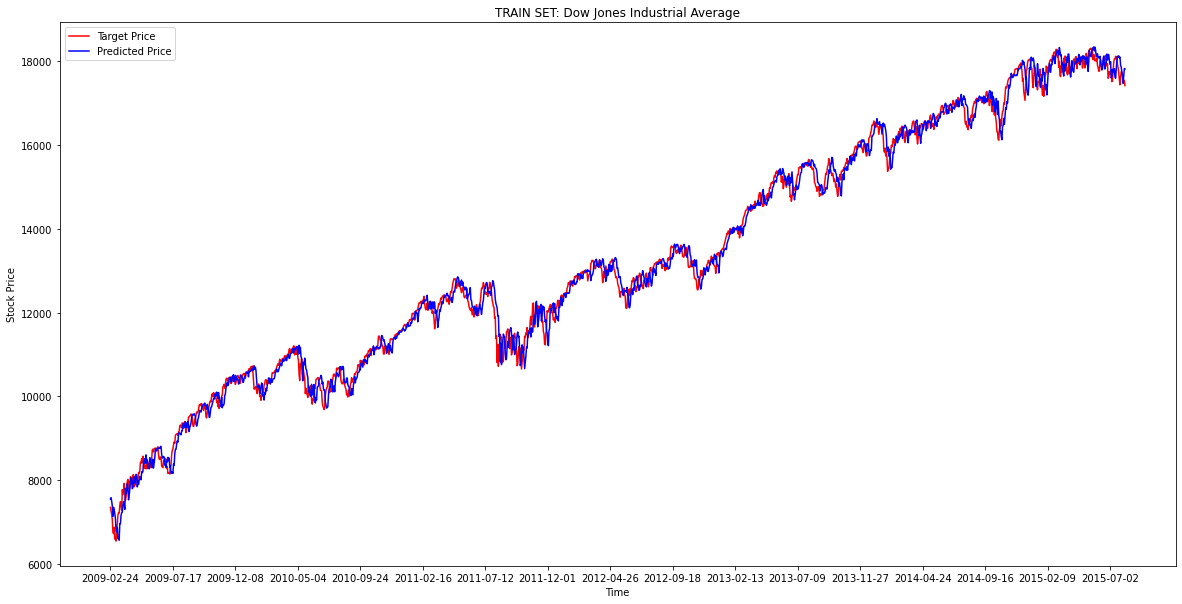

RMSE: 250.8976068421519
MAPE: 0.01537179587323083
MAE: 191.6304071988682


In [15]:
plot_price(model, train_df, 'data/charts/train/', 'TRAIN')

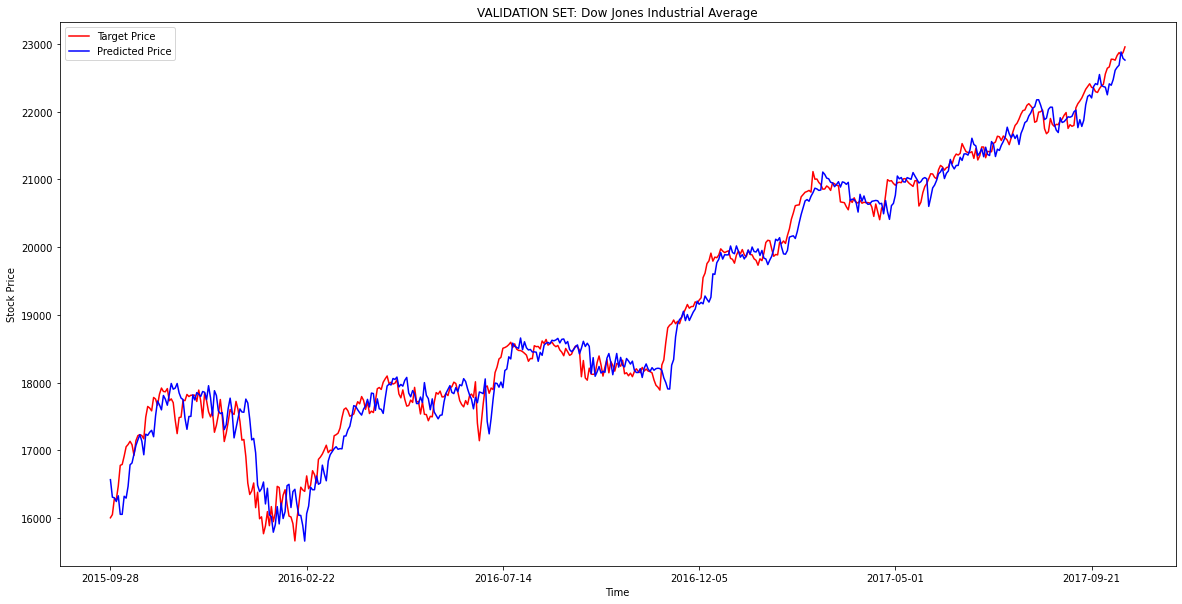

RMSE: 270.582959992705
MAPE: 0.010813394129516775
MAE: 199.47313039691326


In [16]:
plot_price(model, val_df, 'data/charts/val/', 'VALIDATION')

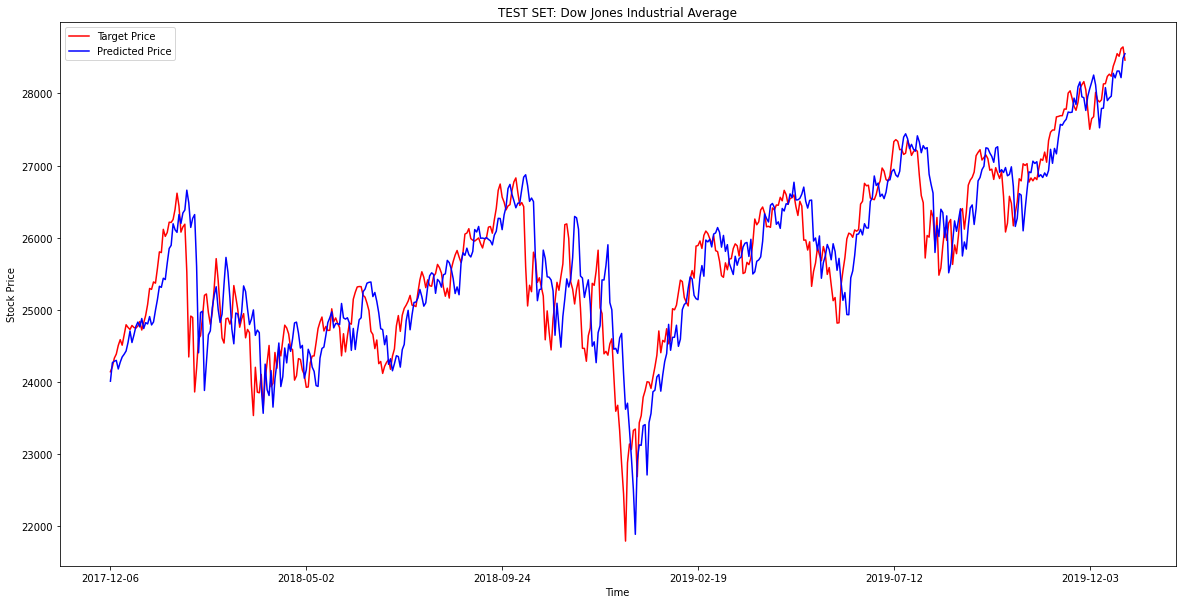

RMSE: 520.5953797046459
MAPE: 0.015317802627400848
MAE: 387.57055612849956


In [17]:
plot_price(model, test_df, 'data/charts/test/', 'TEST')